In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress

In [2]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

In [3]:
from models.backbone import Backbone, EmbeddingNetwork
from models.encoder import EncoderModule
from models.utils.joiner import *
from models.utils.losses import *
from models.utils.metrics import *
from models.unet import UNet

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# H = 32
# W= 32
# bs = 5
# epochs = 36

# seed = 1234

# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

# path = untar_data(URLs.CIFAR)

In [6]:
# transforms = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
#                  get_items=get_image_files, 
#                  splitter=RandomSplitter(),
#                  get_y=parent_label,
#                  item_tfms=Resize(H,W),
#                  batch_tfms=transforms)

# dloader = data.dataloaders(path,bs=bs,device='cuda') 

In [7]:
H = 32
W= 32

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

In [8]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=5, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 5, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

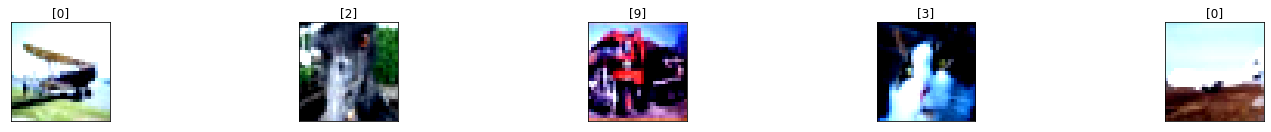

In [11]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [12]:
model_dir = Path.home()/'Luiz/saved_models'
net = load_learner(model_dir/'CIFAR100_2_1e7_1e4_36_noBackbone_GAN.pkl', cpu=False)

In [13]:
model = net.model

In [14]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [15]:
model.model.fc1 = nn.Linear(model.model.fc1.in_features, 10)

In [16]:
trainable_params = ['model.fc1.weight','model.fc1.bias']
for name, param in model.named_parameters():
    if name not in trainable_params:
        param.requires_grad = False
    else:
        print(name, param.requires_grad)

model.fc1.weight True
model.fc1.bias True


In [18]:
model = model.to(device)

In [30]:
#TESTING MODEL ON A SINGLE IMAGE

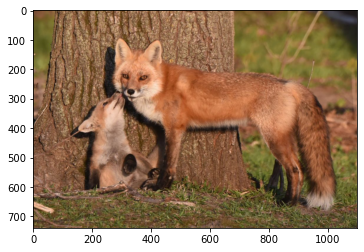

In [29]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [30]:
img = transform2(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 32, 32])


In [32]:
outputs, sattn, pattn, x0, x1 = model(img.to(device))

In [33]:
print("Output shape:", outputs.shape)
#print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 100])
Attention Maps shape: torch.Size([1, 32, 32, 32, 32])


In [17]:
#Training Model

In [18]:
#def add_noise(inputs):
#    noise = torch.randn_like(inputs)*0.2
#    return inputs + noise

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001)
model_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

In [20]:
#learn = Learner(dloader, model, loss_func=criterion, metrics=[Accuracy])

In [22]:
epochs = 3
running_loss_history = [] # training loss - to generate a plot
running_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
val_running_corrects_history = [] # validation accuracy


for e in range(epochs):
  
    start_time = time.time()
    print('-' * 10)
    print('Epoch {}/{}'.format(e+1, epochs))
    print('-' * 10)
    
    best_model_wts = model.state_dict()
    best_val_acc = 0
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        
        #TRAINING THE MODEL
        
        inputs = inputs.to(device) # allow gpu use
        labels = labels.to(device) # allow gpu use
        outputs, _, _, _, _ = model(inputs) #gives the output of the last layer
        loss = criterion(outputs, labels) # comparing outputs and labels using the criteria
        
        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        _, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        running_loss += loss.item() # the sum of the loss of all itens
        running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs

                
    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs, _, _, _, _ = model(val_inputs) #passes the image through the network and get the output
                val_loss = criterion(val_outputs, val_labels) #compare output and labels to get the loss 

                _, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss.item() #same as for training
                val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training

                
    model_lr_scheduler.step()
    
    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_dataset) # the sum of the loss of all itens divided by the number of itens
    epoch_acc = running_corrects.float()/ len(training_dataset) # the sum of correct predictions divided by the number of itens
    running_loss_history.append(epoch_loss) #append to respective list
    running_corrects_history.append(epoch_acc) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_corrects_history.append(val_epoch_acc) #append to respective list
    epoch_time_elapsed = time.time() - start_time
    
    if val_epoch_acc > best_val_acc:
        best_model_wts = model.state_dict()
    
    print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

----------
Epoch 1/3
----------
Epoch training complete in 3m 43s
training loss: 2.4680, acc 0.4635
validation loss: 2.6715, validation acc 0.4876 
----------
Epoch 2/3
----------
Epoch training complete in 3m 57s
training loss: 1.9824, acc 0.5806
validation loss: 2.7630, validation acc 0.5140 
----------
Epoch 3/3
----------
Epoch training complete in 3m 42s
training loss: 1.6476, acc 0.6416
validation loss: 3.0651, validation acc 0.5128 


In [23]:
cifar_img = training_dataset[123][0].unsqueeze(0)
cifar_img = cifar_img.to(device)
cifar_noised = add_noise(cifar_img)
outputs2, sattn2, pattn2 = model(cifar_img)
sattn2 = sattn2.reshape(1,30,30,30,30)
outputs_noised, sattn_noised, pattn_noised = model(cifar_noised)
sattn_noised = sattn_noised.reshape(1,30,30,30,30)
msloss = nn.MSELoss()
print("Penalized self attention:",torch.sum(pattn2)*0.0000001)
print("L2 Recreation loss",msloss(cifar_noised[0],cifar_img[0])*1)

Penalized self attention: tensor(0.0168, device='cuda:0', grad_fn=<MulBackward0>)
L2 Recreation loss tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


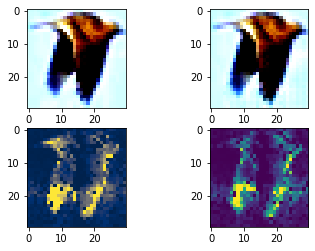

In [27]:
pix_h = 25
pix_w = 15
threshold = torch.sum(sattn2[0,pix_h,pix_w,...])/180#6.3665e-38
threshold_noised = torch.sum(sattn_noised[0,pix_h,pix_w,...])/150#6.3665e-38
plt.subplot(221)
plt.imshow(cifar_img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(cifar_noised[0].cpu().detach().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn2[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest',vmax=threshold)
plt.subplot(224)
plt.imshow(sattn_noised[0,pix_h,pix_w,...].cpu().detach().numpy(),vmax=threshold_noised)
#plt.subplot(222)
#plt.imshow((cifar_img[0]-cifar_noised[0]).cpu().detach().permute(1, 2, 0))

In [29]:
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(),'saved_models/Generator_Encoder_no_bypass_CIFAR10.pth')

In [30]:
torch.save(add_noise.state_dict(),'saved_models/Noise_Generator_CIFAR10.pth')

In [31]:
msloss = nn.MSELoss()
print(torch.sum(pattn2))
print(msloss(cifar_noised[0],cifar_img[0]))

tensor(167522.9844, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)


In [32]:
outputs, sattn, pattn = model(img.to(device))

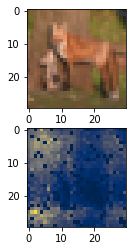

In [38]:
pix_h = 12
pix_w = 15
threshold = torch.sum(sattn[0,pix_h,pix_w,...])/180#6.3665e-38
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest',vmax=threshold)